# Aerial Semantic segmentation

This notebook is originated from: https://www.kaggle.com/code/ligtfeather/semantic-segmentation-is-easy-with-pytorch

# Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing

In [2]:
IMAGE_PATH = '/home/hrl_gpu_1/dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/home/hrl_gpu_1/dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [3]:
os.path.exists(IMAGE_PATH)

True

In [3]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [4]:
#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


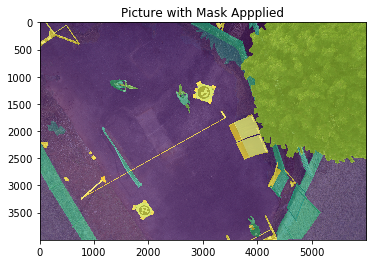

In [5]:
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

# Dataset

In [6]:
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

# Model

In [10]:
model = smp.Unet('mobilenet_v2', \
                 encoder_weights='imagenet', \
                 classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

In [32]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

# Training

In [23]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [22]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [24]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [14]:
model_2 = smp.Unet('efficientnet-b0', \
                 encoder_weights='imagenet', \
                 classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_2 = fit(epoch, model_2, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model_2, 'Unet-efficientnet.pt')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.332 
Epoch:1/15.. Train Loss: 2.891.. Val Loss: 2.332.. Train mIoU:0.029.. Val mIoU: 0.062.. Train Acc:0.176.. Val Acc:0.395.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.332 >> 1.435 
Epoch:2/15.. Train Loss: 1.902.. Val Loss: 1.435.. Train mIoU:0.094.. Val mIoU: 0.122.. Train Acc:0.553.. Val Acc:0.626.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.435 >> 1.035 
Epoch:3/15.. Train Loss: 1.365.. Val Loss: 1.035.. Train mIoU:0.129.. Val mIoU: 0.153.. Train Acc:0.636.. Val Acc:0.715.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.035 >> 0.982 
saving model...
Epoch:4/15.. Train Loss: 1.183.. Val Loss: 0.982.. Train mIoU:0.152.. Val mIoU: 0.173.. Train Acc:0.664.. Val Acc:0.715.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.982 >> 0.923 
Epoch:5/15.. Train Loss: 1.095.. Val Loss: 0.923.. Train mIoU:0.170.. Val mIoU: 0.196.. Train Acc:0.687.. Val Acc:0.730.. Time: 3.98m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.923 >> 0.814 
Epoch:6/15.. Train Loss: 0.998.. Val Loss: 0.814.. Train mIoU:0.190.. Val mIoU: 0.216.. Train Acc:0.707.. Val Acc:0.752.. Time: 3.99m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.814 >> 0.810 
Epoch:7/15.. Train Loss: 0.940.. Val Loss: 0.810.. Train mIoU:0.213.. Val mIoU: 0.250.. Train Acc:0.722.. Val Acc:0.762.. Time: 3.98m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.810 >> 0.720 
Epoch:8/15.. Train Loss: 0.895.. Val Loss: 0.720.. Train mIoU:0.229.. Val mIoU: 0.245.. Train Acc:0.736.. Val Acc:0.787.. Time: 3.96m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.720 >> 0.682 
saving model...
Epoch:9/15.. Train Loss: 0.788.. Val Loss: 0.682.. Train mIoU:0.250.. Val mIoU: 0.276.. Train Acc:0.765.. Val Acc:0.800.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.682 >> 0.650 
Epoch:10/15.. Train Loss: 0.753.. Val Loss: 0.650.. Train mIoU:0.264.. Val mIoU: 0.276.. Train Acc:0.778.. Val Acc:0.798.. Time: 3.94m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.650 >> 0.595 
Epoch:11/15.. Train Loss: 0.685.. Val Loss: 0.595.. Train mIoU:0.284.. Val mIoU: 0.307.. Train Acc:0.794.. Val Acc:0.820.. Time: 3.93m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.595 >> 0.593 
Epoch:12/15.. Train Loss: 0.677.. Val Loss: 0.593.. Train mIoU:0.294.. Val mIoU: 0.307.. Train Acc:0.806.. Val Acc:0.822.. Time: 3.99m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.593 >> 0.563 
Epoch:13/15.. Train Loss: 0.624.. Val Loss: 0.563.. Train mIoU:0.301.. Val mIoU: 0.325.. Train Acc:0.813.. Val Acc:0.831.. Time: 4.01m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.563 >> 0.557 
saving model...
Epoch:14/15.. Train Loss: 0.640.. Val Loss: 0.557.. Train mIoU:0.304.. Val mIoU: 0.330.. Train Acc:0.813.. Val Acc:0.834.. Time: 4.02m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:15/15.. Train Loss: 0.638.. Val Loss: 0.558.. Train mIoU:0.313.. Val mIoU: 0.332.. Train Acc:0.816.. Val Acc:0.832.. Time: 4.01m
Total time: 59.81 m


In [31]:
model_3 = None
model_3 = smp.Unet('vgg11', \
                 encoder_weights='imagenet', \
                 classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_3.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_3 = fit(epoch, model_3, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model_3, 'Unet-vgg.pt')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.880 
Epoch:1/15.. Train Loss: 2.430.. Val Loss: 1.880.. Train mIoU:0.062.. Val mIoU: 0.097.. Train Acc:0.393.. Val Acc:0.515.. Time: 4.10m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.880 >> 1.379 
Epoch:2/15.. Train Loss: 1.657.. Val Loss: 1.379.. Train mIoU:0.112.. Val mIoU: 0.144.. Train Acc:0.581.. Val Acc:0.622.. Time: 4.11m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.379 >> 1.156 
Epoch:3/15.. Train Loss: 1.347.. Val Loss: 1.156.. Train mIoU:0.133.. Val mIoU: 0.157.. Train Acc:0.630.. Val Acc:0.657.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.156 >> 1.052 
saving model...
Epoch:4/15.. Train Loss: 1.229.. Val Loss: 1.052.. Train mIoU:0.151.. Val mIoU: 0.169.. Train Acc:0.653.. Val Acc:0.688.. Time: 4.11m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/15.. Train Loss: 1.194.. Val Loss: 1.056.. Train mIoU:0.155.. Val mIoU: 0.171.. Train Acc:0.661.. Val Acc:0.675.. Time: 4.10m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.056 >> 1.018 
Epoch:6/15.. Train Loss: 1.092.. Val Loss: 1.018.. Train mIoU:0.177.. Val mIoU: 0.171.. Train Acc:0.688.. Val Acc:0.675.. Time: 4.11m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.018 >> 1.012 
Epoch:7/15.. Train Loss: 1.085.. Val Loss: 1.012.. Train mIoU:0.183.. Val mIoU: 0.189.. Train Acc:0.686.. Val Acc:0.688.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.012 >> 0.949 
Epoch:8/15.. Train Loss: 0.974.. Val Loss: 0.949.. Train mIoU:0.199.. Val mIoU: 0.208.. Train Acc:0.714.. Val Acc:0.697.. Time: 4.10m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.949 >> 0.829 
Epoch:9/15.. Train Loss: 0.917.. Val Loss: 0.829.. Train mIoU:0.213.. Val mIoU: 0.227.. Train Acc:0.730.. Val Acc:0.748.. Time: 4.10m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.829 >> 0.814 
saving model...
Epoch:10/15.. Train Loss: 0.858.. Val Loss: 0.814.. Train mIoU:0.230.. Val mIoU: 0.244.. Train Acc:0.749.. Val Acc:0.748.. Time: 4.10m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.814 >> 0.766 
Epoch:11/15.. Train Loss: 0.779.. Val Loss: 0.766.. Train mIoU:0.245.. Val mIoU: 0.265.. Train Acc:0.771.. Val Acc:0.759.. Time: 4.11m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.766 >> 0.708 
Epoch:12/15.. Train Loss: 0.730.. Val Loss: 0.708.. Train mIoU:0.266.. Val mIoU: 0.270.. Train Acc:0.786.. Val Acc:0.787.. Time: 4.13m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.708 >> 0.649 
Epoch:13/15.. Train Loss: 0.702.. Val Loss: 0.649.. Train mIoU:0.274.. Val mIoU: 0.289.. Train Acc:0.793.. Val Acc:0.806.. Time: 4.09m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.649 >> 0.627 
Epoch:14/15.. Train Loss: 0.660.. Val Loss: 0.627.. Train mIoU:0.283.. Val mIoU: 0.305.. Train Acc:0.806.. Val Acc:0.810.. Time: 4.07m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:15/15.. Train Loss: 0.653.. Val Loss: 0.632.. Train mIoU:0.291.. Val mIoU: 0.298.. Train Acc:0.809.. Val Acc:0.810.. Time: 4.09m
Total time: 61.50 m


In [82]:
torch.cuda.empty_cache()

In [47]:
model_4 = smp.Unet('resnet18', \
                 encoder_weights='imagenet', \
                 classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_4.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history_4 = fit(epoch, model_4, train_loader, val_loader, criterion, optimizer, sched)
torch.save(model_4, 'Unet-resnet18.pt')

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.016 
Epoch:1/15.. Train Loss: 2.875.. Val Loss: 2.016.. Train mIoU:0.042.. Val mIoU: 0.112.. Train Acc:0.179.. Val Acc:0.493.. Time: 3.69m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.016 >> 1.914 
Epoch:2/15.. Train Loss: 1.807.. Val Loss: 1.914.. Train mIoU:0.114.. Val mIoU: 0.087.. Train Acc:0.564.. Val Acc:0.454.. Time: 3.71m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.914 >> 1.708 
Epoch:3/15.. Train Loss: 1.465.. Val Loss: 1.708.. Train mIoU:0.123.. Val mIoU: 0.103.. Train Acc:0.610.. Val Acc:0.505.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.708 >> 1.583 
saving model...
Epoch:4/15.. Train Loss: 1.437.. Val Loss: 1.583.. Train mIoU:0.124.. Val mIoU: 0.114.. Train Acc:0.585.. Val Acc:0.502.. Time: 3.70m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.583 >> 1.134 
Epoch:5/15.. Train Loss: 1.354.. Val Loss: 1.134.. Train mIoU:0.132.. Val mIoU: 0.160.. Train Acc:0.612.. Val Acc:0.680.. Time: 3.75m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.134 >> 1.114 
Epoch:6/15.. Train Loss: 1.281.. Val Loss: 1.114.. Train mIoU:0.144.. Val mIoU: 0.159.. Train Acc:0.626.. Val Acc:0.674.. Time: 3.76m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.114 >> 0.980 
Epoch:7/15.. Train Loss: 1.221.. Val Loss: 0.980.. Train mIoU:0.155.. Val mIoU: 0.186.. Train Acc:0.643.. Val Acc:0.718.. Time: 3.75m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:8/15.. Train Loss: 1.125.. Val Loss: 1.016.. Train mIoU:0.167.. Val mIoU: 0.179.. Train Acc:0.675.. Val Acc:0.706.. Time: 3.78m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.016 >> 0.857 
Epoch:9/15.. Train Loss: 1.023.. Val Loss: 0.857.. Train mIoU:0.179.. Val mIoU: 0.189.. Train Acc:0.695.. Val Acc:0.733.. Time: 3.76m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.857 >> 0.801 
saving model...
Epoch:10/15.. Train Loss: 0.974.. Val Loss: 0.801.. Train mIoU:0.189.. Val mIoU: 0.208.. Train Acc:0.710.. Val Acc:0.756.. Time: 3.76m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.801 >> 0.788 
Epoch:11/15.. Train Loss: 0.900.. Val Loss: 0.788.. Train mIoU:0.211.. Val mIoU: 0.229.. Train Acc:0.731.. Val Acc:0.754.. Time: 3.77m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.788 >> 0.719 
Epoch:12/15.. Train Loss: 0.829.. Val Loss: 0.719.. Train mIoU:0.225.. Val mIoU: 0.252.. Train Acc:0.754.. Val Acc:0.778.. Time: 3.76m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.719 >> 0.702 
Epoch:13/15.. Train Loss: 0.783.. Val Loss: 0.702.. Train mIoU:0.240.. Val mIoU: 0.274.. Train Acc:0.769.. Val Acc:0.789.. Time: 3.73m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.702 >> 0.680 
Epoch:14/15.. Train Loss: 0.749.. Val Loss: 0.680.. Train mIoU:0.256.. Val mIoU: 0.278.. Train Acc:0.779.. Val Acc:0.794.. Time: 3.75m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.680 >> 0.665 
saving model...
Epoch:15/15.. Train Loss: 0.733.. Val Loss: 0.665.. Train mIoU:0.258.. Val mIoU: 0.270.. Train Acc:0.782.. Val Acc:0.796.. Time: 3.75m
Total time: 56.10 m


In [37]:
max_lr = 1e-3
epoch = 15
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.019 
Epoch:1/15.. Train Loss: 2.803.. Val Loss: 2.019.. Train mIoU:0.061.. Val mIoU: 0.122.. Train Acc:0.244.. Val Acc:0.557.. Time: 3.84m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 2.019 >> 1.347 
Epoch:2/15.. Train Loss: 1.865.. Val Loss: 1.347.. Train mIoU:0.118.. Val mIoU: 0.155.. Train Acc:0.560.. Val Acc:0.658.. Time: 3.84m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:3/15.. Train Loss: 1.463.. Val Loss: 1.361.. Train mIoU:0.129.. Val mIoU: 0.135.. Train Acc:0.603.. Val Acc:0.613.. Time: 3.82m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.361 >> 1.112 
Epoch:4/15.. Train Loss: 1.328.. Val Loss: 1.112.. Train mIoU:0.142.. Val mIoU: 0.161.. Train Acc:0.621.. Val Acc:0.676.. Time: 3.83m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.112 >> 0.914 
saving model...
Epoch:5/15.. Train Loss: 1.245.. Val Loss: 0.914.. Train mIoU:0.150.. Val mIoU: 0.178.. Train Acc:0.634.. Val Acc:0.724.. Time: 3.82m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:6/15.. Train Loss: 1.171.. Val Loss: 0.966.. Train mIoU:0.171.. Val mIoU: 0.183.. Train Acc:0.662.. Val Acc:0.704.. Time: 3.81m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:7/15.. Train Loss: 1.089.. Val Loss: 1.015.. Train mIoU:0.189.. Val mIoU: 0.196.. Train Acc:0.683.. Val Acc:0.700.. Time: 3.80m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.015 >> 0.850 
Epoch:8/15.. Train Loss: 0.992.. Val Loss: 0.850.. Train mIoU:0.209.. Val mIoU: 0.224.. Train Acc:0.704.. Val Acc:0.743.. Time: 3.82m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.850 >> 0.778 
Epoch:9/15.. Train Loss: 0.931.. Val Loss: 0.778.. Train mIoU:0.222.. Val mIoU: 0.261.. Train Acc:0.723.. Val Acc:0.766.. Time: 3.83m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.778 >> 0.732 
Epoch:10/15.. Train Loss: 0.873.. Val Loss: 0.732.. Train mIoU:0.240.. Val mIoU: 0.278.. Train Acc:0.738.. Val Acc:0.784.. Time: 3.83m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.732 >> 0.688 
Epoch:11/15.. Train Loss: 0.800.. Val Loss: 0.688.. Train mIoU:0.260.. Val mIoU: 0.277.. Train Acc:0.766.. Val Acc:0.791.. Time: 3.85m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.688 >> 0.634 
saving model...
Epoch:12/15.. Train Loss: 0.729.. Val Loss: 0.634.. Train mIoU:0.282.. Val mIoU: 0.306.. Train Acc:0.789.. Val Acc:0.814.. Time: 3.85m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.634 >> 0.619 
Epoch:13/15.. Train Loss: 0.706.. Val Loss: 0.619.. Train mIoU:0.282.. Val mIoU: 0.306.. Train Acc:0.793.. Val Acc:0.815.. Time: 3.85m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.619 >> 0.614 
Epoch:14/15.. Train Loss: 0.656.. Val Loss: 0.614.. Train mIoU:0.297.. Val mIoU: 0.313.. Train Acc:0.807.. Val Acc:0.819.. Time: 3.82m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 4 time
Epoch:15/15.. Train Loss: 0.667.. Val Loss: 0.621.. Train mIoU:0.297.. Val mIoU: 0.315.. Train Acc:0.806.. Val Acc:0.818.. Time: 3.86m
Total time: 57.45 m


In [30]:
torch.save(model, 'Unet-Mobilenet.pt')

In [43]:
model = torch.load('Unet-Mobilenet.pt')
model.eval()
model_2 = torch.load('Unet-efficientnet.pt')
model_2.eval()

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [33]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

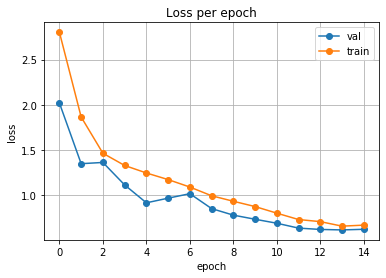

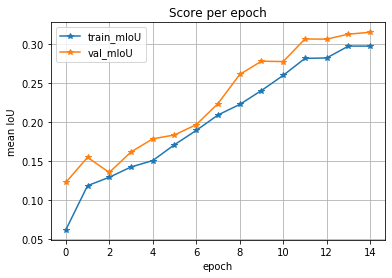

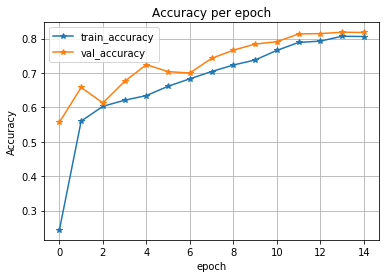

In [40]:
# with mobilenet
plot_loss(history)
plot_score(history)
plot_acc(history)

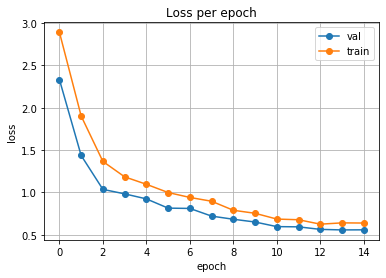

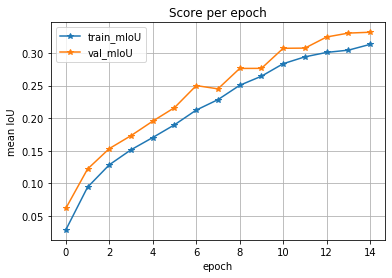

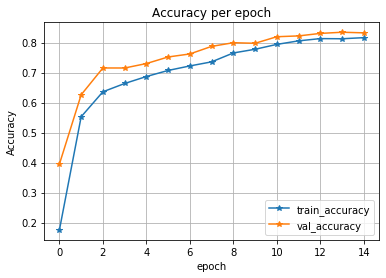

In [62]:
# with efficientnet
plot_loss(history_2)
plot_score(history_2)
plot_acc(history_2)

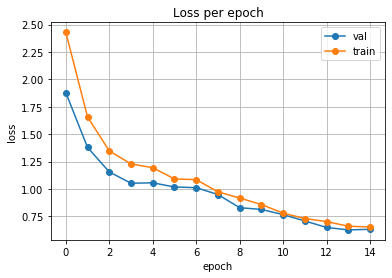

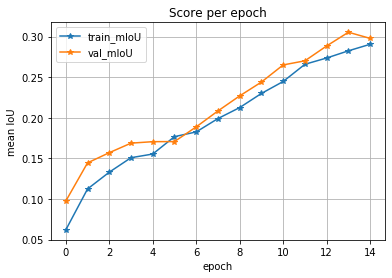

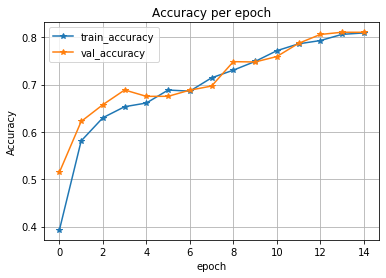

In [34]:
# with VGG
plot_loss(history_3)
plot_score(history_3)
plot_acc(history_3)

# Evaluation

In [20]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

## Result

In [17]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [18]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [36]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [63]:
mob_miou = miou_score(model, test_set)
print(f'Test Set with {len(mob_miou)} datas: mIoU', np.mean(mob_miou))

  0%|          | 0/40 [00:00<?, ?it/s]

Test Set with 40 datas: mIoU 0.35946302282259324


In [38]:
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [64]:
mob_acc = pixel_acc(model, test_set)
print('Test Set Pixel Accuracy', np.mean(mob_acc))

  0%|          | 0/40 [00:00<?, ?it/s]

Test Set Pixel Accuracy 0.8416637844509548


torch.Size([448, 640])


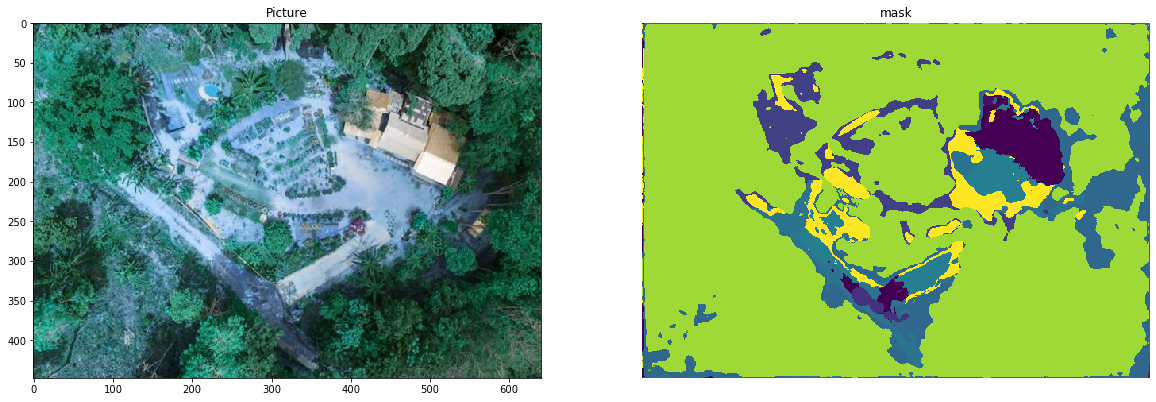

In [108]:
img = cv2.imread("/home/hrl_gpu_1/Downloads/test_aerial.jpg")

def predict_image(model, image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    with torch.no_grad():
        image = image.unsqueeze(0)       
        output = model(image)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked

pred_mask = predict_image(model, img)
print(pred_mask.shape)

# plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Picture');

ax2.imshow(pred_mask)
ax2.set_title('mask')
ax2.set_axis_off()

unlabeled paved-area dirt grass gravel water rocks pool vegetation roof wall window 
door fence fence-pole person dog car bicycle tree bald-tree ar-marker obstacle conflicting 

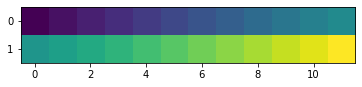

In [112]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

labels = ['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']

for x in range(0, 12):
    print(labels[x], end =" ")
ax = plt.subplot()
im = ax.imshow(np.arange(24).reshape((2, 12)))
# print(np.arange(20).reshape((2, 10)))
print('')
for x in range(12, 24):
    print(labels[x], end =" ")


In [52]:
import time
start = time.time()
pred_mask = predict_image(model_4, img)
print(time.time() - start )

0.021636486053466797


tensor([[3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        ...,
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3],
        [3, 3, 3,  ..., 3, 3, 3]])


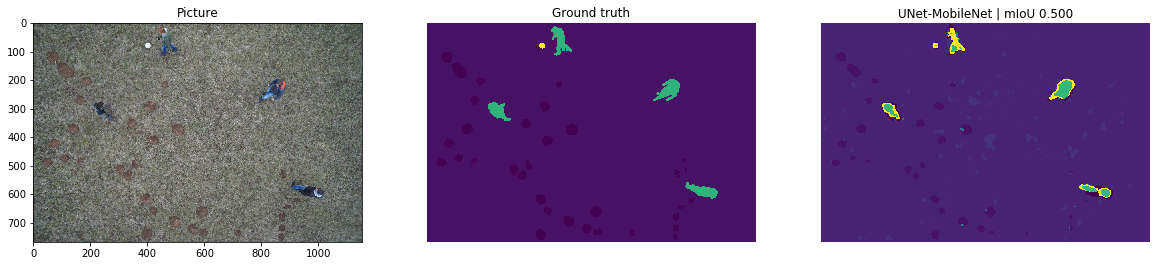

In [76]:
image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model_3, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

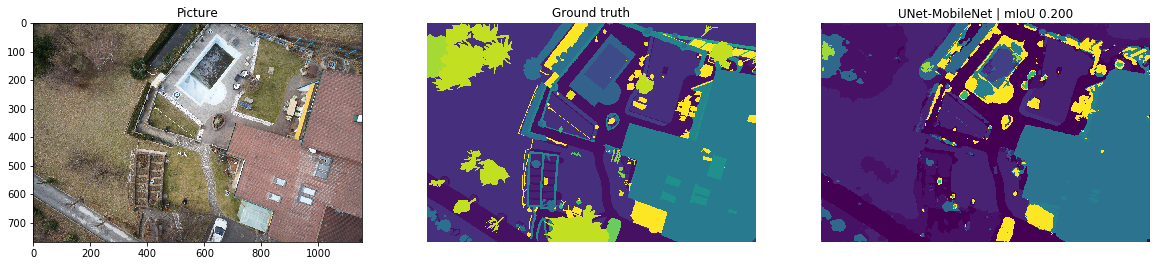

In [114]:
image2, mask2 = test_set[13]
pred_mask2, score2 = predict_image_mask_miou(model_3, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

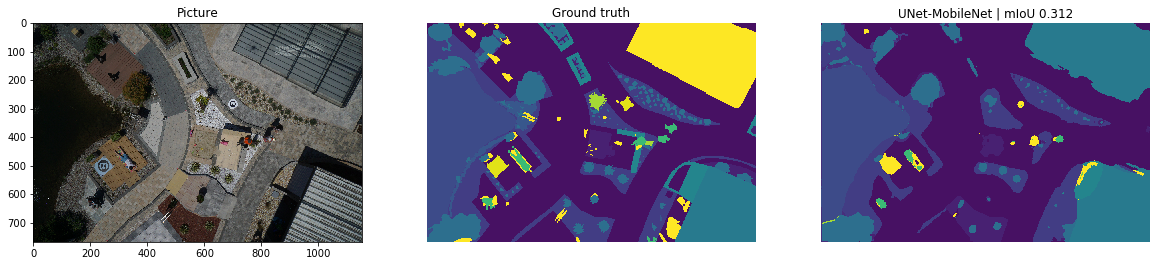

In [66]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [84]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

dump_tensors()

Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 32 × 3 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 32 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 64 × 32 × 3 × 3
Parameter: GPU pinned 512 × 256 × 1 × 1
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 64 × 64 × 1 × 1
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 256 × 64 × 1 × 1
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 32 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 32 × 64 × 1 × 1
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 128 × 32 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 256 × 64 × 1 × 1
Parameter: GPU pinned 256
Parameter: GPU pinned 256
Parameter: GPU pinned 128 × 256 × 1 × 1
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU

/home/hrl_gpu_1/.local/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


Parameter: GPU pinned 32 × 3 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 1 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 8 × 32 × 1 × 1
Parameter: GPU pinned 8
Parameter: GPU pinned 32 × 8 × 1 × 1
Parameter: GPU pinned 32
Parameter: GPU pinned 16 × 32 × 1 × 1
Parameter: GPU pinned 16
Parameter: GPU pinned 16
Parameter: GPU pinned 96 × 16 × 1 × 1
Parameter: GPU pinned 96
Parameter: GPU pinned 96
Parameter: GPU pinned 96 × 1 × 3 × 3
Parameter: GPU pinned 96
Parameter: GPU pinned 96
Parameter: GPU pinned 4 × 96 × 1 × 1
Parameter: GPU pinned 4
Parameter: GPU pinned 96 × 4 × 1 × 1
Parameter: GPU pinned 96
Parameter: GPU pinned 24 × 96 × 1 × 1
Parameter: GPU pinned 24
Parameter: GPU pinned 24
Parameter: GPU pinned 144 × 24 × 1 × 1
Parameter: GPU pinned 144
Parameter: GPU pinned 144
Parameter: GPU pinned 144 × 1 × 3 × 3
Parameter: GPU pinned 6 × 144 × 1 × 1
Parameter: GPU pinned 6
Parameter: GPU pinned 144 × 6 × 1 × 1


Parameter: GPU pinned 512 × 512 × 3 × 3
Parameter: GPU pinned 512
Parameter: GPU pinned 512 × 512 × 3 × 3
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 512 × 512 × 3 × 3
Parameter: GPU pinned 512
Parameter: GPU pinned 512
Parameter: GPU pinned 128 × 768 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 128 × 3 × 3
Parameter: GPU pinned 128
Parameter: GPU pinned 128
Parameter: GPU pinned 64 × 384 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 64 × 64 × 3 × 3
Parameter: GPU pinned 64
Parameter: GPU pinned 64
Parameter: GPU pinned 32 × 192 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 32 × 32 × 3 × 3
Parameter: GPU pinned 32
Parameter: GPU pinned 32
Parameter: GPU pinned 16 × 32 × 3 × 3
Parameter: GPU pinned 16
Parameter: GPU pinned 16
Parameter: GPU pinned 16 × 16 × 3 × 3
Parameter: GPU pinned 16
Parameter: GPU pinned 16
Tensor: GPU pinned 512
Tensor: GPU p

Tensor: GPU pinned 10 × 240 × 1 × 1
Tensor: GPU pinned 10
Tensor: GPU pinned 10
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 40 × 240 × 1 × 1
Tensor: GPU pinned 40 × 240 × 1 × 1
Tensor: GPU pinned 40
Tensor: GPU pinned 40
Tensor: GPU pinned 40
Tensor: GPU pinned 40
Tensor: GPU pinned 240 × 40 × 1 × 1
Tensor: GPU pinned 240 × 40 × 1 × 1
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240 × 1 × 3 × 3
Tensor: GPU pinned 240 × 1 × 3 × 3
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 10 × 240 × 1 × 1
Tensor: GPU pinned 10 × 240 × 1 × 1
Tensor: GPU pinned 10
Tensor: GPU pinned 10
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240 × 10 × 1 × 1
Tensor: GPU pinned 240
Tensor: GPU pinned 240
Tensor: GPU pinned 80 × 240 × 1 × 1
Tensor: GPU pinned 80 × 240 × 1 × 1
Tensor: GP